# Basic HEMS implementation using MILP

In [1]:
import cvxpy as cp
import numpy as np

## Constants

In [2]:
from HEMS.const import DT_DEFAULT

T = 24 * int(1 / DT_DEFAULT) - 1  # number of time steps per day
solver = cp.HIGHS
print(f"DT_DEFAULT = {DT_DEFAULT} h, T = {T} steps/day")

DT_DEFAULT = 0.25 h, T = 95 steps/day


## EV control prototyping

In [3]:
from HEMS.load import EV

In [4]:
ev = EV(T)

# Simple time-of-use electricity price signal [€/kWh]
# Cheap at night (0–7h, 21–24h), expensive during the day (7–21h)
price = np.where(
    np.arange(T) < 7 * 4,      # 00:00–07:00
    0.05,
    np.where(
        np.arange(T) >= 21 * 4,    # 21:00–24:00
        0.05,
        0.25,                        # 07:00–21:00
    ),
)

# Schedule two trips: 8:00–18:00 consuming 30 kWh, and 19:00–21:00 consuming 25 kWh
ev.schedule_trips([(8 * 4, 18 * 4, 30.0), (19 * 4, 20 * 4, 25.0)])

# Cost-minimising objective: pay as little as possible for charging
objective = cp.Minimize(ev.dt * (price @ ev.P))

prob = cp.Problem(objective, ev.constraints())

assert prob.is_dcp(), "Problem is not DCP compliant"
assert prob.is_dpp(), "Problem is not DPP compliant"

prob.solve(solver=solver, verbose=False)
print(f"Status : {prob.status}")
print(f"Cost   : {prob.value:.4f} €")


Status : optimal
Cost   : 4.7611 €


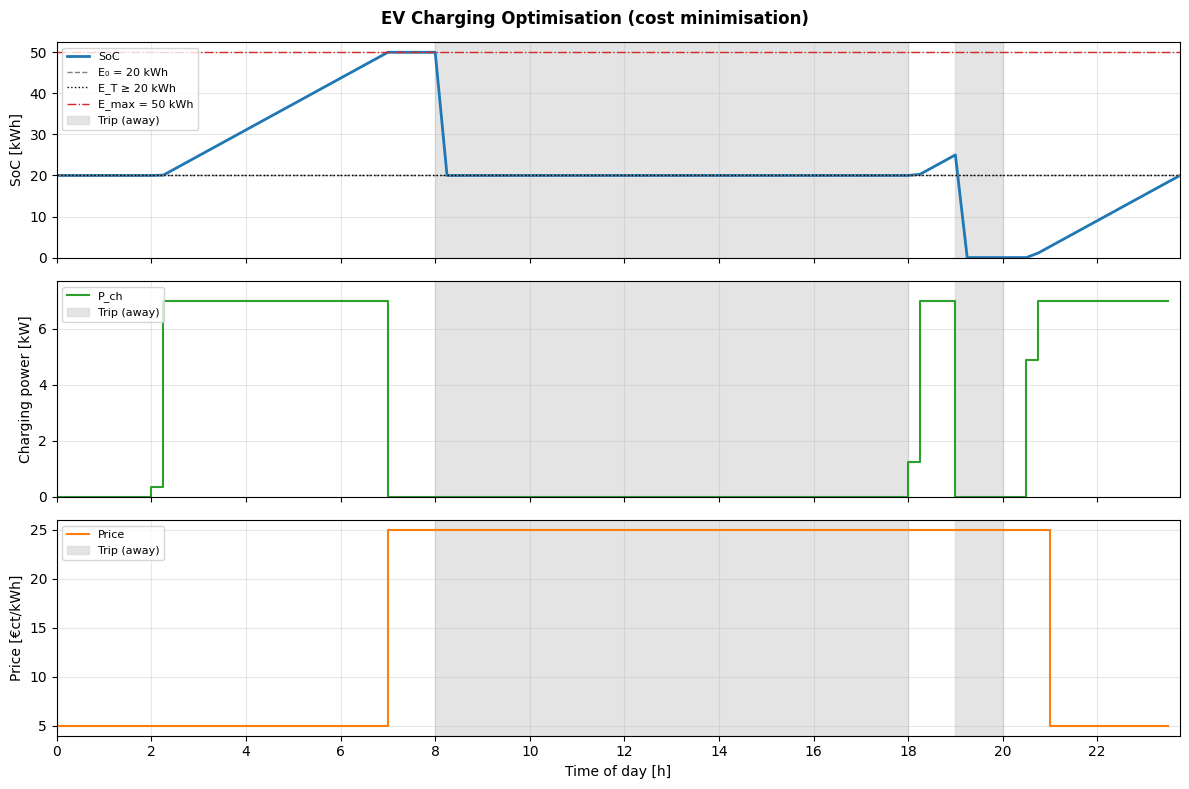

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

t_power = np.arange(T) * ev.dt          # time axis for power/price [h]
t_soc   = np.arange(T + 1) * ev.dt      # time axis for SoC [h]

# Extract solved values
soc   = ev.E.value                       # kWh,  shape (T+1,)
p_ch  = ev.P_ch.value                    # kW,   shape (T,)
avail = ev.a.value                       # 0/1,  shape (T,)


def shade_trips(ax, t_power, avail, dt, **kwargs):
    """Shade each contiguous unavailability window on ax."""
    unavail = (avail == 0).astype(int)
    edges = np.diff(np.concatenate(([0], unavail, [0])))
    starts = t_power[np.where(edges == 1)[0]]
    ends   = t_power[np.where(edges == -1)[0] - 1] + dt
    first = True
    for s, e in zip(starts, ends):
        ax.axvspan(s, e, label="Trip (away)" if first else None, **kwargs)
        first = False


fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
fig.suptitle("EV Charging Optimisation (cost minimisation)", fontweight="bold")

trip_kwargs = dict(color="lightgrey", alpha=0.6)

# --- Panel 1: State of Charge ---
ax = axes[0]
ax.plot(t_soc, soc, color="tab:blue", lw=2, label="SoC")
ax.axhline(ev.E_0.value, color="grey",    ls="--", lw=1, label=f"E₀ = {ev.E_0.value:.0f} kWh")
ax.axhline(ev.E_T.value, color="black",   ls=":",  lw=1, label=f"E_T ≥ {ev.E_T.value:.0f} kWh")
ax.axhline(ev.E_max,     color="tab:red", ls="-.", lw=1, label=f"E_max = {ev.E_max:.0f} kWh")
shade_trips(ax, t_power, avail, ev.dt, **trip_kwargs)
ax.set_ylabel("SoC [kWh]")
ax.set_ylim(0, ev.E_max * 1.05)
ax.legend(loc="upper left", fontsize=8)
ax.grid(True, alpha=0.3)

# --- Panel 2: Charging power ---
ax = axes[1]
ax.step(t_power, p_ch, where="post", color="tab:green", lw=1.5, label="P_ch")
shade_trips(ax, t_power, avail, ev.dt, **trip_kwargs)
ax.set_ylabel("Charging power [kW]")
ax.set_ylim(0, ev.P_ch_max * 1.1)
ax.legend(loc="upper left", fontsize=8)
ax.grid(True, alpha=0.3)

# --- Panel 3: Electricity price ---
ax = axes[2]
ax.step(t_power, price * 100, where="post", color="tab:orange", lw=1.5, label="Price")
shade_trips(ax, t_power, avail, ev.dt, **trip_kwargs)
grey_patch = mpatches.Patch(**trip_kwargs, label="Trip (away)")
ax.legend(handles=[ax.get_lines()[0], grey_patch], loc="upper left", fontsize=8)
ax.set_ylabel("Price [€ct/kWh]")
ax.set_xlabel("Time of day [h]")
ax.set_xlim(0, T * ev.dt)
ax.set_xticks(range(0, int(T * ev.dt) + 1, 2))
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Solar generation prototyping

In [6]:
from HEMS.solar import Solar
from HEMS.weather import fetch_open_meteo, resample_weather
import pandas as pd

# --- Fetch historical weather data for Amsterdam, June 2025 ---
weather = fetch_open_meteo(
    latitude=52.37,
    longitude=4.90,
    start_date="2025-06-01",
    end_date="2025-06-30",
    timezone="Europe/Amsterdam",
)
print(f"Fetched {len(weather)} hourly records")

# --- Resample to DT_DEFAULT (15-min) ---
weather = resample_weather(weather, dt=DT_DEFAULT)
print(f"Resampled to {len(weather)} records at {DT_DEFAULT*60:.0f}-min resolution")
print(weather.head())

Fetched 720 hourly records
Resampled to 2877 records at 15-min resolution
                           ghi  dni  dhi  temp_air  wind_speed
time                                                          
2025-06-01 00:00:00+02:00  0.0  0.0  0.0     17.30    2.472222
2025-06-01 00:15:00+02:00  0.0  0.0  0.0     17.15    2.263889
2025-06-01 00:30:00+02:00  0.0  0.0  0.0     17.00    2.055556
2025-06-01 00:45:00+02:00  0.0  0.0  0.0     16.85    1.847222
2025-06-01 01:00:00+02:00  0.0  0.0  0.0     16.70    1.638889


In [7]:
# --- Create a 5 kWp south-facing PV system in Amsterdam ---
T_sol = len(weather)

solar = Solar(
    T=T_sol,
    dt=DT_DEFAULT,
    pdc0=5.0,           # 5 kWp array
    pac0=5.0,           # 5 kW inverter
    surface_tilt=35.0,  # 35° tilt
    surface_azimuth=180.0,  # south-facing
    latitude=52.37,
    longitude=4.90,
    timezone="Europe/Amsterdam",
    curtailable=False,
)

# Compute AC generation from the fetched weather data
pac_kw = solar.compute_generation(
    times=weather.index,
    ghi=weather["ghi"].to_numpy(),
    temp_air=weather["temp_air"].to_numpy(),
    wind_speed=weather["wind_speed"].to_numpy(),
    dni=weather["dni"].to_numpy(),
    dhi=weather["dhi"].to_numpy(),
)

monthly_yield = np.sum(pac_kw) * DT_DEFAULT
peak_power = pac_kw.max()
print(f"Time steps    : {T_sol} ({DT_DEFAULT*60:.0f}-min resolution)")
print(f"Peak AC power : {peak_power:.2f} kW")
print(f"Monthly yield : {monthly_yield:.1f} kWh")
print(f"Capacity factor: {monthly_yield / (solar.pdc0 * T_sol * DT_DEFAULT) * 100:.1f}%")

Time steps    : 2877 (15-min resolution)
Peak AC power : 4.31 kW
Monthly yield : 873.5 kWh
Capacity factor: 24.3%


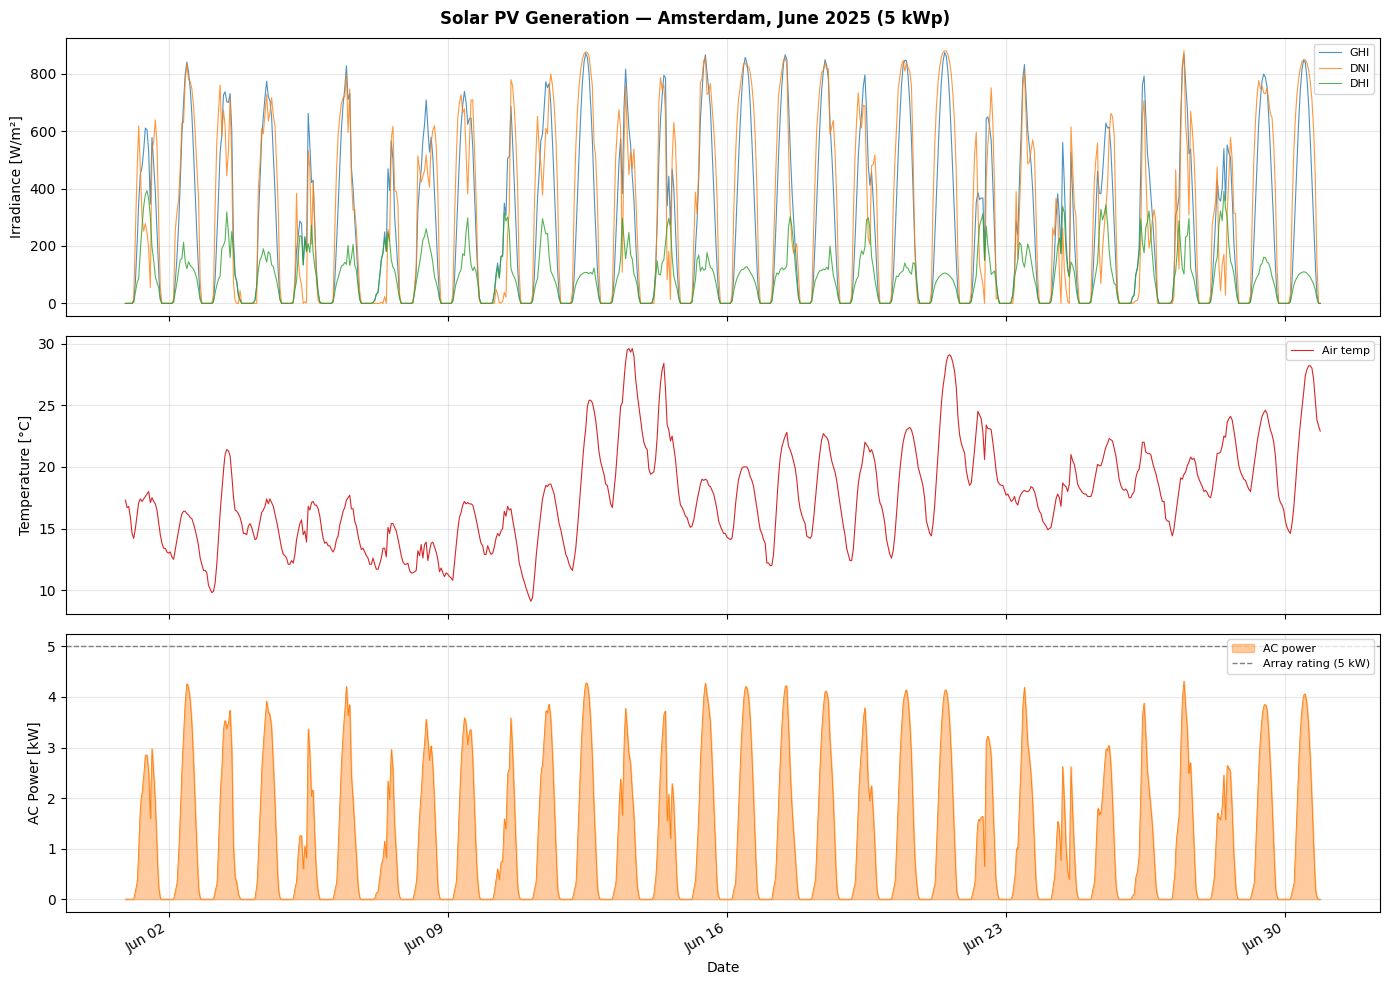

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
fig.suptitle("Solar PV Generation — Amsterdam, June 2025 (5 kWp)", fontweight="bold")

times = weather.index

# --- Panel 1: Irradiance ---
ax = axes[0]
ax.plot(times, weather["ghi"], lw=0.8, alpha=0.8, label="GHI")
ax.plot(times, weather["dni"], lw=0.8, alpha=0.8, label="DNI")
ax.plot(times, weather["dhi"], lw=0.8, alpha=0.8, label="DHI")
ax.set_ylabel("Irradiance [W/m²]")
ax.legend(loc="upper right", fontsize=8)
ax.grid(True, alpha=0.3)

# --- Panel 2: Temperature ---
ax = axes[1]
ax.plot(times, weather["temp_air"], lw=0.8, color="tab:red", label="Air temp")
ax.set_ylabel("Temperature [°C]")
ax.legend(loc="upper right", fontsize=8)
ax.grid(True, alpha=0.3)

# --- Panel 3: AC power output ---
ax = axes[2]
ax.fill_between(times, pac_kw, alpha=0.4, color="tab:orange", label="AC power")
ax.plot(times, pac_kw, lw=0.6, color="tab:orange")
ax.axhline(solar.pdc0, color="grey", ls="--", lw=1, label=f"Array rating ({solar.pdc0:.0f} kW)")
ax.set_ylabel("AC Power [kW]")
ax.set_xlabel("Date")
ax.legend(loc="upper right", fontsize=8)
ax.grid(True, alpha=0.3)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
fig.autofmt_xdate(rotation=30)

plt.tight_layout()
plt.show()

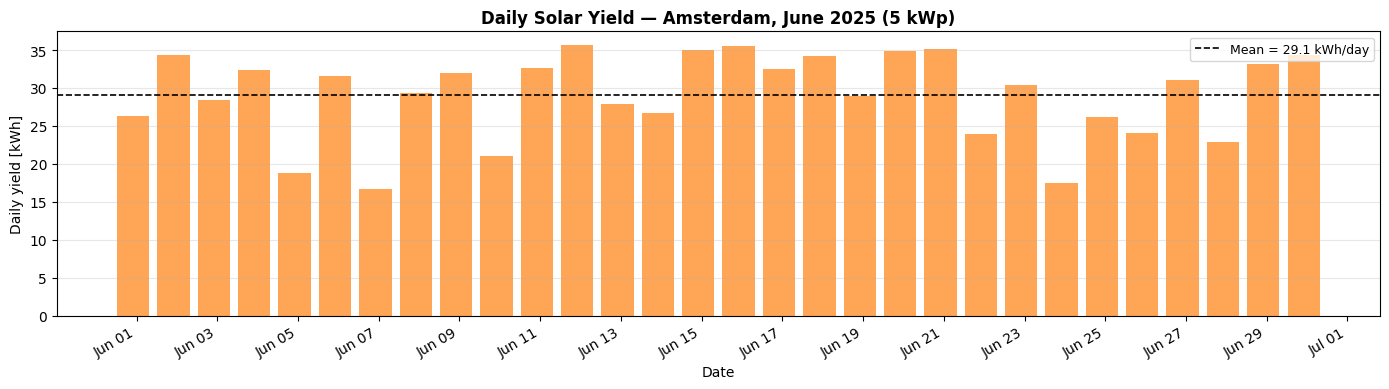

In [9]:
# --- Daily yield bar chart ---
daily_yield = pd.Series(pac_kw * DT_DEFAULT, index=weather.index).resample("D").sum()

fig, ax = plt.subplots(figsize=(14, 4))
ax.bar(daily_yield.index, daily_yield.values, width=0.8, color="tab:orange", alpha=0.7)
ax.axhline(daily_yield.mean(), color="black", ls="--", lw=1.2,
           label=f"Mean = {daily_yield.mean():.1f} kWh/day")
ax.set_ylabel("Daily yield [kWh]")
ax.set_xlabel("Date")
ax.set_title("Daily Solar Yield — Amsterdam, June 2025 (5 kWp)", fontweight="bold")
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
fig.autofmt_xdate(rotation=30)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, axis="y")
plt.tight_layout()
plt.show()

### Curtailment demo (single day)

We create a **curtailable** solar model for the sunniest day in June and impose a
feed-in limit. The optimiser decides how much generation to keep versus curtail.

In [10]:
# --- Pick the sunniest day from the month ---
best_day = daily_yield.idxmax().strftime("%Y-%m-%d")
day_mask = weather.index.normalize() == pd.Timestamp(best_day, tz="Europe/Amsterdam")
weather_day = weather.loc[day_mask]
T_day = len(weather_day)

print(f"Sunniest day: {best_day}  ({daily_yield.max():.1f} kWh)")
print(f"Time steps:   {T_day}  (dt={DT_DEFAULT} h)")

# --- Curtailable solar model for that day ---
solar_curt = Solar(
    T=T_day,
    dt=DT_DEFAULT,
    pdc0=5.0,
    pac0=5.0,
    surface_tilt=35.0,
    surface_azimuth=180.0,
    latitude=52.37,
    longitude=4.90,
    timezone="Europe/Amsterdam",
    curtailable=True,  # <-- optimiser can curtail
)

# Compute the maximum available generation
pac_day = solar_curt.compute_generation(
    times=weather_day.index,
    ghi=weather_day["ghi"].values,
    temp_air=weather_day["temp_air"].values,
    wind_speed=weather_day["wind_speed"].values,
    dni=weather_day["dni"].values,
    dhi=weather_day["dhi"].values,
)

# --- Feed-in limit: curtail anything above 3 kW ---
feed_in_limit = 3.0  # kW

constraints = solar_curt.constraints()
constraints += [solar_curt.P <= feed_in_limit]

# Maximise total generation subject to the feed-in cap
objective = cp.Maximize(cp.sum(solar_curt.P))
prob = cp.Problem(objective, constraints)
prob.solve(solver=solver)

p_curt = solar_curt.P.value
energy_available = np.sum(pac_day) * DT_DEFAULT
energy_delivered = np.sum(p_curt) * DT_DEFAULT
energy_curtailed = energy_available - energy_delivered

print(f"\nStatus        : {prob.status}")
print(f"Available     : {energy_available:.2f} kWh")
print(f"Delivered     : {energy_delivered:.2f} kWh")
print(f"Curtailed     : {energy_curtailed:.2f} kWh ({energy_curtailed/energy_available*100:.1f}%)")

Sunniest day: 2025-06-12  (35.7 kWh)
Time steps:   96  (dt=0.25 h)

Status        : optimal
Available     : 35.68 kWh
Delivered     : 30.21 kWh
Curtailed     : 5.47 kWh (15.3%)


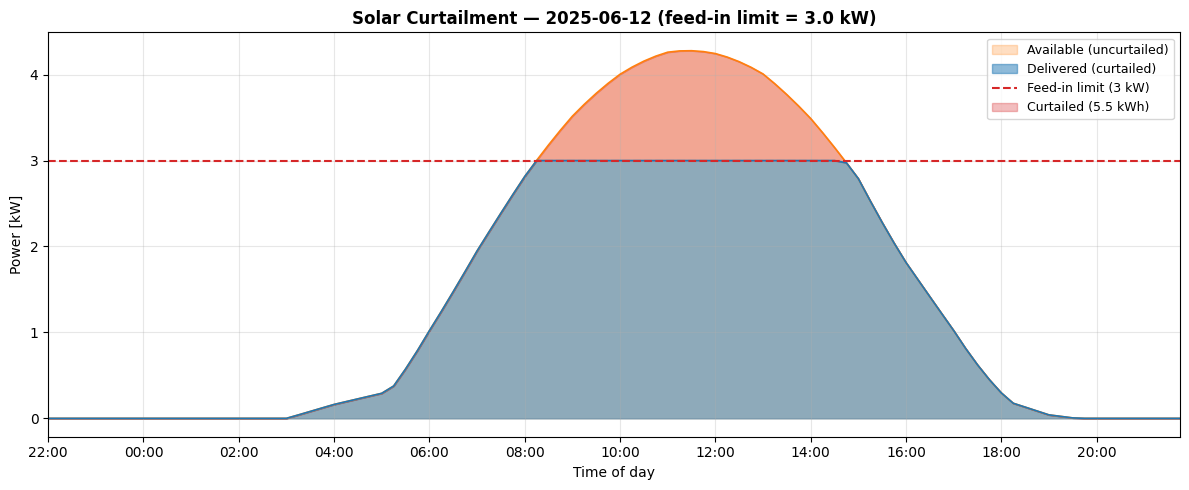

In [11]:
# --- Curtailment visualisation ---
hours = np.arange(T_day) * DT_DEFAULT
t_day = weather_day.index

fig, ax = plt.subplots(figsize=(12, 5))

# Available generation (uncurtailed)
ax.fill_between(t_day, pac_day, alpha=0.25, color="tab:orange", label="Available (uncurtailed)")
ax.plot(t_day, pac_day, lw=1.2, color="tab:orange")

# Delivered (after curtailment)
ax.fill_between(t_day, p_curt, alpha=0.5, color="tab:blue", label="Delivered (curtailed)")
ax.plot(t_day, p_curt, lw=1.2, color="tab:blue")

# Feed-in limit
ax.axhline(feed_in_limit, color="tab:red", ls="--", lw=1.5,
           label=f"Feed-in limit ({feed_in_limit:.0f} kW)")

# Shade curtailed energy
ax.fill_between(t_day, p_curt, pac_day, alpha=0.3, color="tab:red",
                label=f"Curtailed ({energy_curtailed:.1f} kWh)")

ax.set_ylabel("Power [kW]")
ax.set_xlabel("Time of day")
ax.set_title(f"Solar Curtailment — {best_day} (feed-in limit = {feed_in_limit} kW)", fontweight="bold")
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.set_xlim(t_day[0], t_day[-1])
ax.legend(loc="upper right", fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Heat pump prototyping (1R1C model)

Non-controllable fixed load using a 1R1C building envelope and a
Carnot-based COP model.  Parameters represent a typical Dutch row house
(`H = 0.20 kW/°C`, `C = 8 kWh/°C`, `T_set = 20 °C`, `T_supply = 35 °C`).

We fetch **winter** weather (January 2025, Amsterdam) so the heat pump
faces realistic cold-weather conditions.

In [12]:
from HEMS.heat_pump import HeatPump

# --- Fetch cold winter weather (January 2025, Amsterdam) ---
weather_winter = fetch_open_meteo(
    latitude=52.37,
    longitude=4.90,
    start_date="2025-01-01",
    end_date="2025-01-31",
    timezone="Europe/Amsterdam",
)
weather_winter = resample_weather(weather_winter, dt=DT_DEFAULT)
print(f"Winter weather: {len(weather_winter)} records at {DT_DEFAULT*60:.0f}-min")
print(f"Temp range: {weather_winter['temp_air'].min():.1f} – {weather_winter['temp_air'].max():.1f} °C")

# Use 7 coldest consecutive days
daily_mean_temp = weather_winter["temp_air"].resample("D").mean()
# rolling 7-day mean → find the window with lowest average
rolling_temp = daily_mean_temp.rolling(7).mean()
cold_week_end = rolling_temp.idxmin()
cold_week_start = cold_week_end - pd.Timedelta(days=6)
print(f"Coldest week: {cold_week_start.strftime('%Y-%m-%d')} to {cold_week_end.strftime('%Y-%m-%d')} "
      f"(mean {rolling_temp.min():.1f} °C)")

mask = (weather_winter.index >= cold_week_start) & (
    weather_winter.index < cold_week_end + pd.Timedelta(days=1)
)
weather_hp = weather_winter.loc[mask]
T_hp = len(weather_hp)
hp_days = 7

# Shared building + HP parameters (only T_supply differs)
hp_kwargs = dict(
    T_amb=weather_hp["temp_air"].to_numpy(),
    dt=DT_DEFAULT,
    H=0.20, C=8.0, T_set=20.0, T_in_0=20.0,
    eta_carnot=0.45, P_hp_max=8.0, Q_int=0.7,
)

# --- Scenario A: Low-temperature (underfloor heating) ---
hp_lo = HeatPump(**hp_kwargs, T_supply=35.0)
P_el_lo = hp_lo.P.value

# --- Scenario B: High-temperature (radiator system) ---
hp_hi = HeatPump(**hp_kwargs, T_supply=55.0)
P_el_hi = hp_hi.P.value

print(f"\n{'':30s} {'T_supply=35°C':>14s}  {'T_supply=55°C':>14s}")
print(f"{'Peak elec power [kW]':30s} {P_el_lo.max():14.2f}  {P_el_hi.max():14.2f}")
print(f"{'Total elec [kWh]':30s} {np.sum(P_el_lo)*DT_DEFAULT:14.1f}  {np.sum(P_el_hi)*DT_DEFAULT:14.1f}")
print(f"{'COP range':30s} {hp_lo.cop.min():.2f}–{hp_lo.cop.max():.2f}       {hp_hi.cop.min():.2f}–{hp_hi.cop.max():.2f}")
print(f"{'Q_hp peak [kW]':30s} {hp_lo.Q_hp.max():14.2f}  {hp_hi.Q_hp.max():14.2f}")

Winter weather: 2973 records at 15-min
Temp range: -2.3 – 12.3 °C
Coldest week: 2025-01-16 to 2025-01-22 (mean 1.0 °C)

                                T_supply=35°C   T_supply=55°C
Peak elec power [kW]                     1.01            1.46
Total elec [kWh]                        128.9           191.7
COP range                      3.72–4.99       2.58–3.09
Q_hp peak [kW]                           3.76            3.76


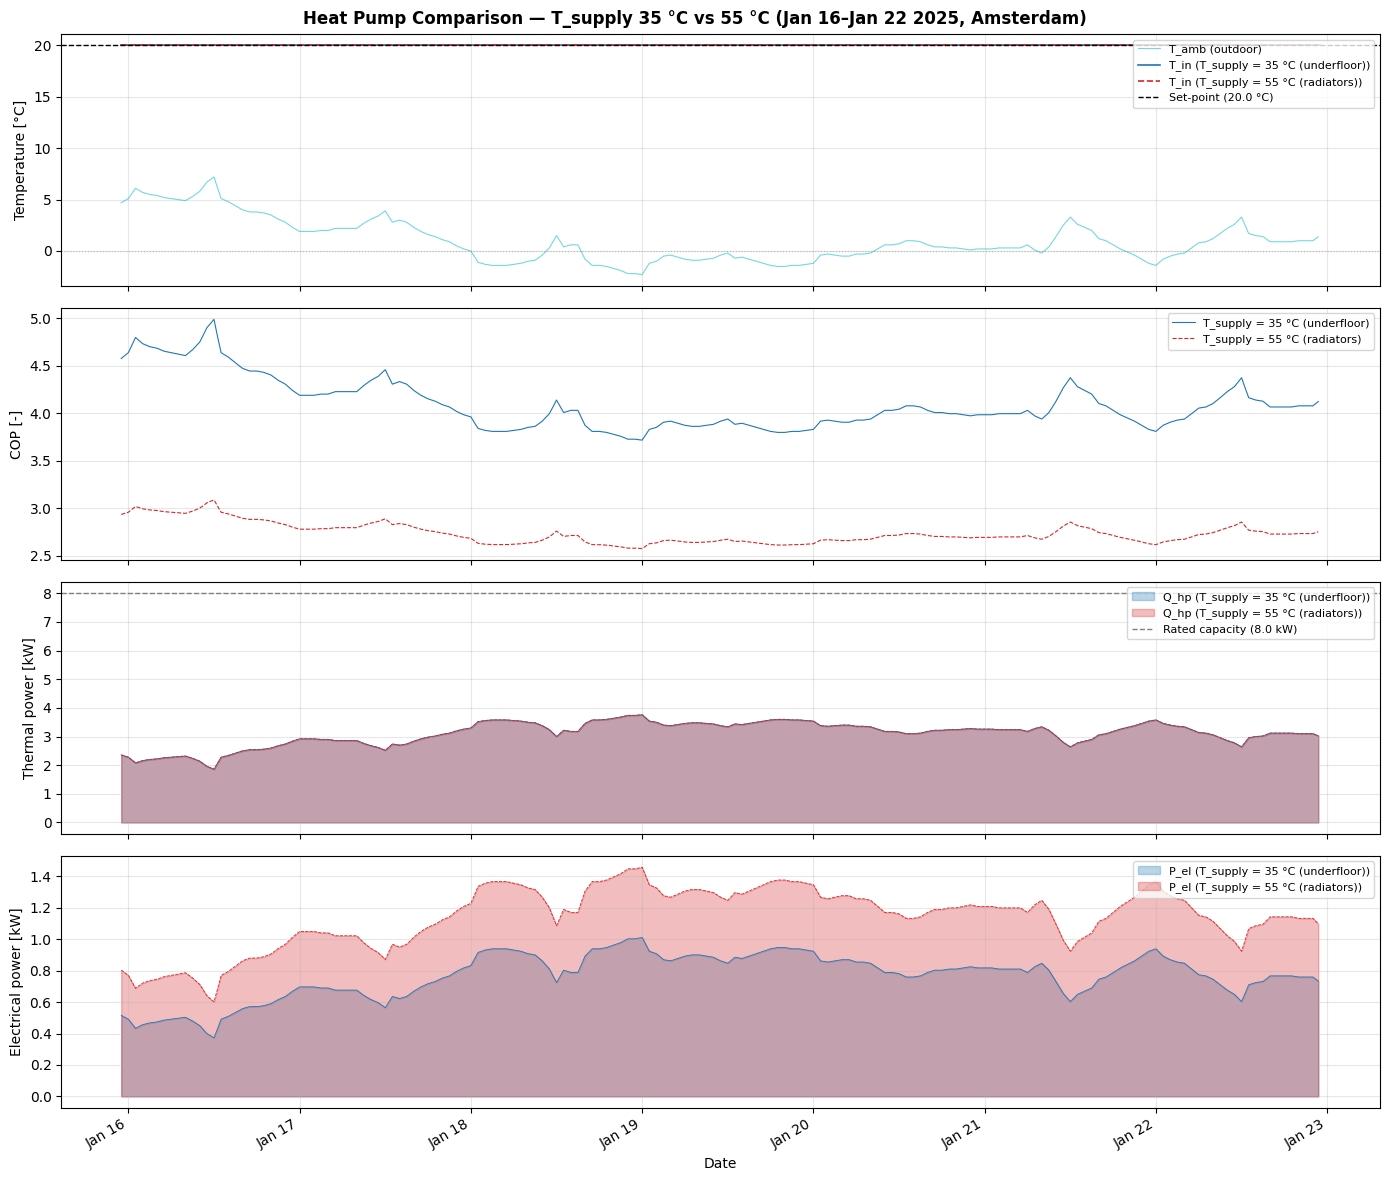

In [13]:
# --- Heat pump comparison: T_supply = 35 °C vs 55 °C (4-panel) ---
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

t_hp = weather_hp.index
t_hp_in = weather_hp.index.append(
    pd.DatetimeIndex([weather_hp.index[-1] + pd.Timedelta(hours=DT_DEFAULT)])
)

fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)
fig.suptitle(
    f"Heat Pump Comparison — T_supply 35 °C vs 55 °C "
    f"({cold_week_start.strftime('%b %d')}–{cold_week_end.strftime('%b %d %Y')}, Amsterdam)",
    fontweight="bold",
)

c_lo, c_hi = "tab:blue", "tab:red"
label_lo, label_hi = "T_supply = 35 °C (underfloor)", "T_supply = 55 °C (radiators)"

# --- Panel 1: Temperatures ---
ax = axes[0]
ax.plot(t_hp, hp_lo.T_amb[:T_hp], lw=0.8, color="tab:cyan", alpha=0.6, label="T_amb (outdoor)")
ax.plot(t_hp_in, hp_lo.T_in, lw=1.2, color=c_lo, label=f"T_in ({label_lo})")
ax.plot(t_hp_in, hp_hi.T_in, lw=1.2, color=c_hi, ls="--", label=f"T_in ({label_hi})")
ax.axhline(hp_lo.T_set, color="black", ls="--", lw=1, label=f"Set-point ({hp_lo.T_set} °C)")
ax.axhline(0, color="grey", ls=":", lw=0.8, alpha=0.5)
ax.set_ylabel("Temperature [°C]")
ax.legend(loc="upper right", fontsize=8)
ax.grid(True, alpha=0.3)

# --- Panel 2: COP ---
ax = axes[1]
ax.plot(t_hp, hp_lo.cop, lw=0.8, color=c_lo, label=label_lo)
ax.plot(t_hp, hp_hi.cop, lw=0.8, color=c_hi, ls="--", label=label_hi)
ax.set_ylabel("COP [-]")
ax.legend(loc="upper right", fontsize=8)
ax.grid(True, alpha=0.3)

# --- Panel 3: Thermal power (identical — same building) ---
ax = axes[2]
ax.fill_between(t_hp, hp_lo.Q_hp, alpha=0.3, color=c_lo, label=f"Q_hp ({label_lo})")
ax.plot(t_hp, hp_lo.Q_hp, lw=0.6, color=c_lo)
ax.fill_between(t_hp, hp_hi.Q_hp, alpha=0.3, color=c_hi, label=f"Q_hp ({label_hi})")
ax.plot(t_hp, hp_hi.Q_hp, lw=0.6, color=c_hi, ls="--")
ax.axhline(hp_lo.P_hp_max, color="grey", ls="--", lw=1, label=f"Rated capacity ({hp_lo.P_hp_max} kW)")
ax.set_ylabel("Thermal power [kW]")
ax.legend(loc="upper right", fontsize=8)
ax.grid(True, alpha=0.3)

# --- Panel 4: Electrical power ---
ax = axes[3]
ax.fill_between(t_hp, P_el_lo, alpha=0.3, color=c_lo, label=f"P_el ({label_lo})")
ax.plot(t_hp, P_el_lo, lw=0.6, color=c_lo)
ax.fill_between(t_hp, P_el_hi, alpha=0.3, color=c_hi, label=f"P_el ({label_hi})")
ax.plot(t_hp, P_el_hi, lw=0.6, color=c_hi, ls="--")
ax.set_ylabel("Electrical power [kW]")
ax.set_xlabel("Date")
ax.legend(loc="upper right", fontsize=8)
ax.grid(True, alpha=0.3)

ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
fig.autofmt_xdate(rotation=30)

plt.tight_layout()
plt.show()

## HEMS Rolling-Horizon Simulation — March 2025

We run a **cost-optimal** day-ahead schedule for 31 days, re-solving the HEMS problem every 24 hours with updated forecasts:

| Component | Specification |
|---|---|
| **PV** | 5 kWp, south-facing (35° tilt), curtailable |
| **Battery** | 10 kWh / 5 kW, 95% round-trip efficiency |
| **Heat pump** | Air-source, T_supply = 35 °C (underfloor), 1R1C model |
| **EV** | 50 kWh battery, 7 kW charger, 10 kWh/day commute (weekdays) |
| **Base load** | 0.5 kW constant |
| **Price** | Real NL day-ahead spot prices (Jeroen Punt, 2025) — 15-min resolution |
| **Feed-in** | 70% of spot price (approximation of Dutch saldering phase-out) |

In [14]:
# Fetch March 2025 weather for Amsterdam (+ 1 extra day for boundary)
weather_mar = fetch_open_meteo(
    latitude=52.37, longitude=4.90,
    start_date="2025-03-01", end_date="2025-04-01",
    timezone="Europe/Amsterdam",
)
weather_mar = resample_weather(weather_mar, dt=DT_DEFAULT)
print(f"Weather: {len(weather_mar)} records at {DT_DEFAULT*60:.0f}-min resolution")
print(f"Range: {weather_mar.index[0]} to {weather_mar.index[-1]}")

Weather: 3065 records at 15-min resolution
Range: 2025-03-01 00:00:00+01:00 to 2025-04-01 23:00:00+02:00


In [15]:
from HEMS.hems import HEMS, Objective
from HEMS.battery import Battery
from HEMS.base import BaseLoad
from HEMS.heat_pump import HeatPump
from pathlib import Path

# --- Load real NL day-ahead spot prices (15-min, EUR/kWh excl. tax) ---
price_csv = Path(__file__).resolve().parent / "../../day-ahead-prices-nl/data/" \
            "jeroen_punt_nl_dynamische_stroomprijzen_jaar_2025.csv" \
            if "__file__" in dir() else \
            Path("/home/langestefan/dev/projects/2026/langestefan.github.io/"
                 "_posts/energy/day-ahead-prices-nl/data/"
                 "jeroen_punt_nl_dynamische_stroomprijzen_jaar_2025.csv")
prices_nl = pd.read_csv(
    price_csv, sep=";", decimal=",",
    parse_dates=["datum_nl"], index_col="datum_nl",
)
prices_nl.index = prices_nl.index.tz_localize("Europe/Amsterdam", ambiguous="NaT", nonexistent="NaT")
prices_nl = prices_nl[prices_nl.index.notna()]
prices_nl = prices_nl.rename(columns={"prijs_excl_belastingen": "price_eur_kwh"})

# Extract March 2025 prices
prices_mar = prices_nl.loc["2025-03-01":"2025-03-31", "price_eur_kwh"]
print(f"Loaded {len(prices_mar)} price records for March 2025")
print(f"  Range : {prices_mar.index[0]} → {prices_mar.index[-1]}")
print(f"  Mean  : {prices_mar.mean():.4f} EUR/kWh")
print(f"  Min   : {prices_mar.min():.4f} EUR/kWh")
print(f"  Max   : {prices_mar.max():.4f} EUR/kWh")

# Feed-in price = 70% of spot (simplified saldering phase-out)
FEED_IN_FRAC = 0.70

# --- Components (24-hour horizon, T=95) ---
base_load = BaseLoad(name="base_load", P_base=0.5)

pv = Solar(
    T=T, dt=DT_DEFAULT, pdc0=5.0, curtailable=True,
    latitude=52.37, longitude=4.90,
    surface_tilt=35.0, surface_azimuth=180.0,
    timezone="Europe/Amsterdam",
)

battery = Battery(T=T, dt=DT_DEFAULT, E_max=10.0, P_ch_max=5.0, P_dis_max=5.0)
ev = EV(T=T, dt=DT_DEFAULT, name="EV")

# Initialise HP with first day's weather
w0 = weather_mar.loc["2025-03-01"].iloc[:T]
hp = HeatPump(T_amb=w0["temp_air"].values, dt=DT_DEFAULT, name="HP", T_supply=35.0)

# Use first day's price to initialise the HEMS problem
p0 = prices_mar.loc["2025-03-01"].values[:T]
fi0 = np.maximum(p0 * FEED_IN_FRAC, 0.0)

# --- Build HEMS (compiled once, re-solved daily) ---
hems = HEMS(
    loads=[base_load, hp], pvs=[pv], evs=[ev], battery=battery,
    price=p0, feed_in_price=fi0, objective="cost",
)

print(f"\nHEMS compiled — DCP: {hems.problem.is_dcp()}, DPP: {hems.problem.is_dpp()}")
print(f"Loads: {[l.name for l in hems.loads]}")
print(f"PV: {[p.name for p in hems.pvs]}, Battery: {battery.name}, EV: {ev.name}")

Loaded 2972 price records for March 2025
  Range : 2025-03-01 00:00:00+01:00 → 2025-03-31 23:45:00+02:00
  Mean  : 0.0917 EUR/kWh
  Min   : -0.0330 EUR/kWh
  Max   : 0.2469 EUR/kWh

HEMS compiled — DCP: True, DPP: True
Loads: ['base_load', 'HP']
PV: ['Solar'], Battery: Battery, EV: EV


In [20]:
import time

N_DAYS = 31
dates_march = pd.date_range("2025-03-01", periods=N_DAYS, freq="D")

# Daily aggregates
daily = pd.DataFrame(0.0, index=dates_march, columns=[
    "import_kWh", "export_kWh", "pv_kWh", "sc_kWh",
    "hp_kWh", "ev_kWh", "base_kWh", "cost_eur",
    "avg_price",
])

# 15-min timeseries storage
ts_chunks = {k: [] for k in ["P_import", "P_export", "P_pv", "P_bat",
                               "P_hp", "P_ev", "P_base", "E_bat", "price"]}
ts_idx = []

# Initial conditions
battery.E_0.value = battery.E_max / 2
ev.E_0.value = 20.0

skipped = []
t_start = time.perf_counter()

for d in range(N_DAYS):
    ds = dates_march[d].strftime("%Y-%m-%d")

    # Positional slice: T consecutive 15-min steps from midnight.
    # This handles DST spring-forward days (23 h) by naturally
    # extending a few steps into the next calendar day.
    midnight = pd.Timestamp(ds, tz="Europe/Amsterdam")

    w_start = weather_mar.index.searchsorted(midnight)
    w = weather_mar.iloc[w_start:w_start + T]
    if len(w) < T:
        skipped.append(ds)
        continue

    p_start = prices_mar.index.searchsorted(midnight)
    day_prices = prices_mar.iloc[p_start:p_start + T].values
    if len(day_prices) < T:
        skipped.append(ds)
        continue

    # Clamp negative prices to zero for the optimiser
    price_day = np.maximum(day_prices, 0.0)
    feed_in_day = np.maximum(day_prices * FEED_IN_FRAC, 0.0)

    # Update HEMS price parameters
    hems.price.value = price_day
    hems.feed_in_price.value = feed_in_day

    # Update solar forecast
    pv.compute_generation(
        times=w.index, ghi=w["ghi"].values, temp_air=w["temp_air"].values,
        wind_speed=w["wind_speed"].values, dni=w["dni"].values, dhi=w["dhi"].values,
    )

    # Update heat pump (re-simulate 1R1C with today's weather)
    _hp = HeatPump(T_amb=w["temp_air"].values, dt=DT_DEFAULT, T_supply=35.0)
    hp.P.value = _hp.P.value

    # Update EV (weekdays: commute 08:00-18:00, 10 kWh; weekends: home)
    if dates_march[d].weekday() < 5:
        ev.schedule_trips([(8 * 4, 18 * 4, 10.0)])
    else:
        ev.schedule_trips([])
    ev.E_T.value = ev.E_0.value        # daily cycling
    battery.E_T.value = battery.E_0.value  # daily cycling

    # Solve
    res = hems.solve()

    # Record daily aggregates
    imp, exp = res["P_import"], res["P_export"]
    pv_gen = hems.total_pv_generation
    daily.loc[dates_march[d]] = [
        np.sum(imp) * DT_DEFAULT, np.sum(exp) * DT_DEFAULT,
        np.sum(pv_gen) * DT_DEFAULT, (np.sum(pv_gen) - np.sum(exp)) * DT_DEFAULT,
        np.sum(hp.P.value) * DT_DEFAULT,
        np.sum(np.maximum(ev.P.value, 0)) * DT_DEFAULT,
        np.sum(base_load.P.value) * DT_DEFAULT,
        res["cost"],
        np.mean(day_prices),
    ]

    # Record 15-min timeseries
    ts_idx.extend(w.index.tolist())
    for k, v in [("P_import", imp), ("P_export", exp), ("P_pv", pv_gen),
                  ("P_bat", battery.P.value), ("P_hp", hp.P.value),
                  ("P_ev", ev.P.value), ("P_base", base_load.P.value),
                  ("E_bat", battery.E.value[:-1]), ("price", day_prices)]:
        ts_chunks[k].append(v.copy())

    # Advance SoC for next day
    battery.E_0.value = float(battery.E.value[-1])
    ev.E_0.value = float(ev.E.value[-1])

elapsed = time.perf_counter() - t_start

# Build 15-min DataFrame
ts_march = pd.DataFrame(
    {k: np.concatenate(v) for k, v in ts_chunks.items()},
    index=pd.DatetimeIndex(ts_idx),
)

# Print summary
if skipped:
    print(f"Skipped {len(skipped)} day(s): {', '.join(skipped)}\n")

tot = daily.sum()
pv_t, sc_t = tot["pv_kWh"], tot["sc_kWh"]
load_t = tot["hp_kWh"] + tot["ev_kWh"] + tot["base_kWh"]
n_solved = N_DAYS - len(skipped)

print(f"March 2025 HEMS -- {n_solved} days solved in {elapsed:.1f} s")
print(f"Real NL day-ahead spot prices (excl. tax)")
print("=" * 55)
print(f"  PV generation   : {pv_t:7.1f} kWh")
print(f"  Grid import     : {tot['import_kWh']:7.1f} kWh")
print(f"  Grid export     : {tot['export_kWh']:7.1f} kWh")
print(f"  Self-consumed   : {sc_t:7.1f} kWh  ({sc_t / max(pv_t, 1) * 100:.1f}%)")
print(f"  Self-reliance   : {sc_t / max(sc_t + tot['import_kWh'], 1) * 100:.1f}%")
print(f"  HP consumption  : {tot['hp_kWh']:7.1f} kWh")
print(f"  EV consumption  : {tot['ev_kWh']:7.1f} kWh")
print(f"  Base load       : {tot['base_kWh']:7.1f} kWh")
print(f"  Total cost      : EUR {tot['cost_eur']:7.2f}")
print(f"  Avg daily cost  : EUR {daily['cost_eur'].mean():7.2f}")
print(f"  Avg spot price  : {daily['avg_price'].mean():.4f} EUR/kWh")

March 2025 HEMS -- 31 days solved in 0.5 s
Real NL day-ahead spot prices (excl. tax)
  PV generation   :   550.7 kWh
  Grid import     :   707.3 kWh
  Grid export     :   348.6 kWh
  Self-consumed   :   202.1 kWh  (36.7%)
  Self-reliance   : 22.2%
  HP consumption  :   308.0 kWh
  EV consumption  :   233.3 kWh
  Base load       :   368.1 kWh
  Total cost      : EUR   54.19
  Avg daily cost  : EUR    1.75
  Avg spot price  : 0.0916 EUR/kWh


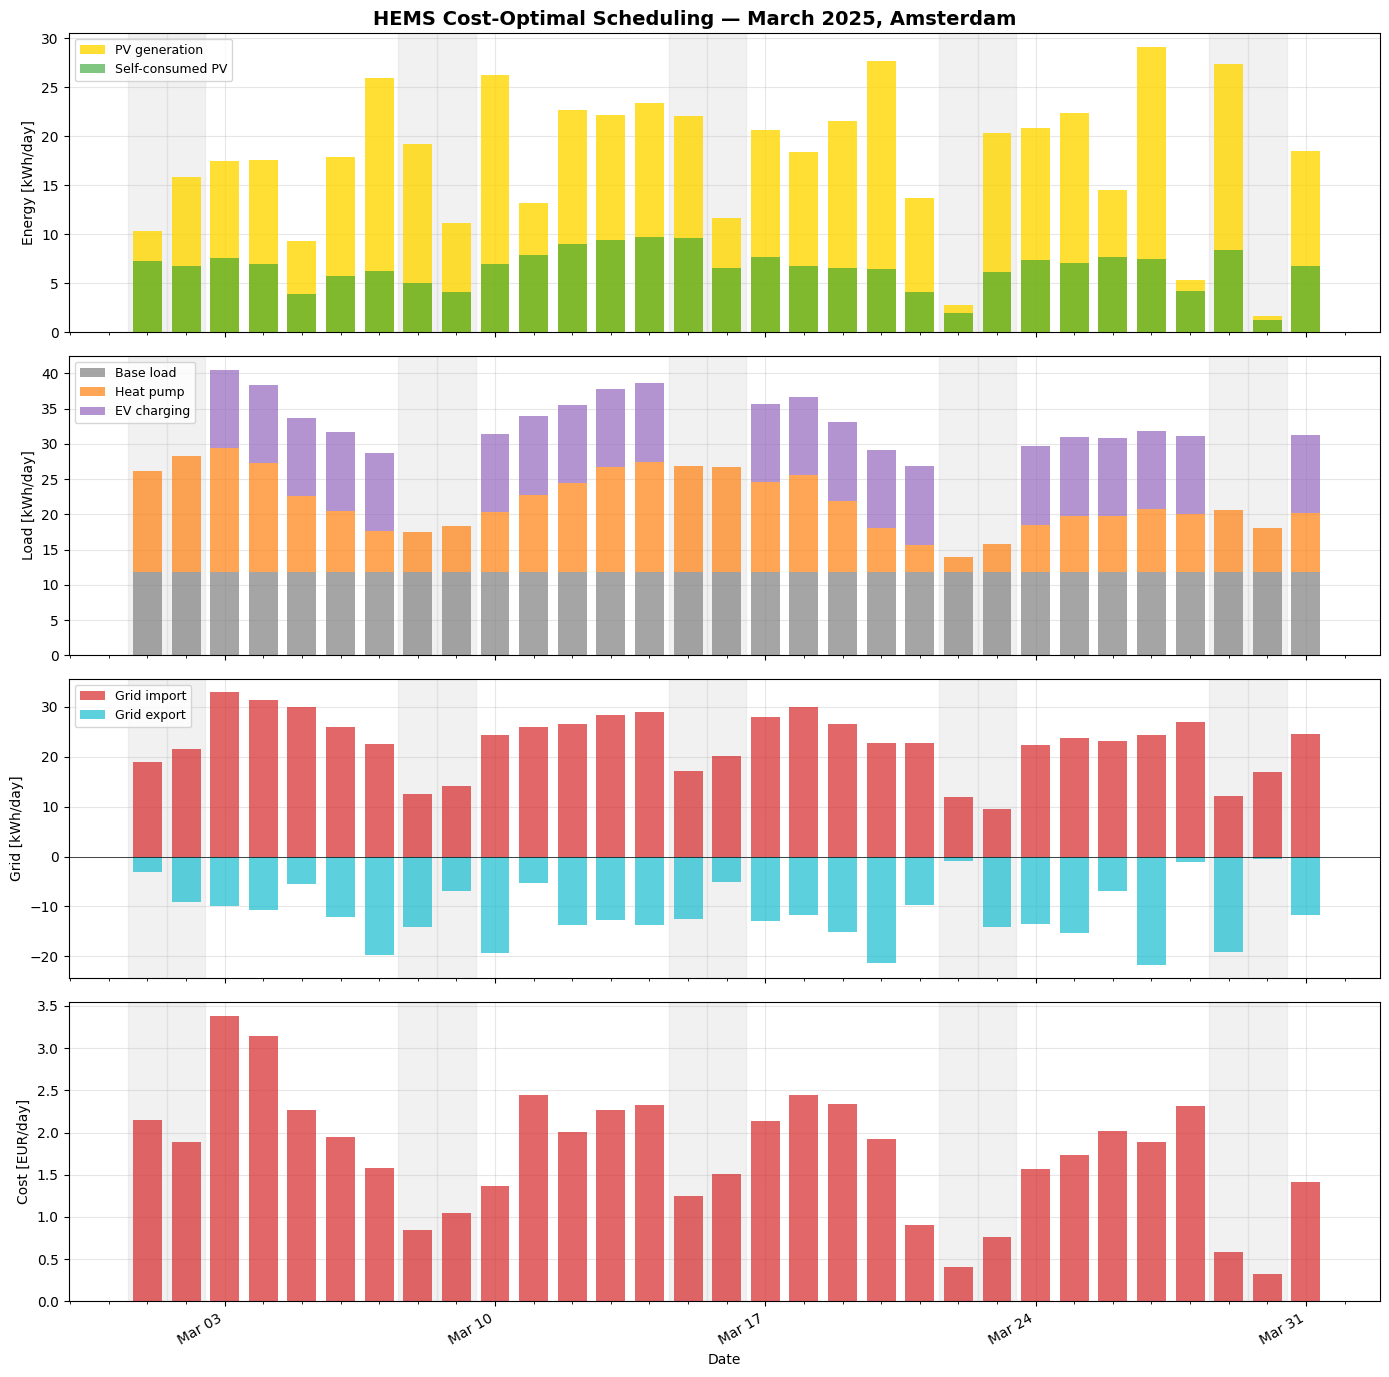

In [21]:
# --- Monthly overview: 4-panel daily bar chart ---
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, axes = plt.subplots(4, 1, figsize=(14, 14), sharex=True)
fig.suptitle(
    "HEMS Cost-Optimal Scheduling — March 2025, Amsterdam",
    fontweight="bold", fontsize=14,
)

# Shade weekends
for ax in axes:
    for d in dates_march:
        if d.weekday() >= 5:
            ax.axvspan(
                d - pd.Timedelta(hours=12), d + pd.Timedelta(hours=12),
                color="lightgrey", alpha=0.3, zorder=0,
            )

bw = pd.Timedelta(hours=18)  # bar width

# Panel 1: PV generation & self-consumption
ax = axes[0]
ax.bar(daily.index, daily["pv_kWh"], width=bw, color="gold",
       alpha=0.8, label="PV generation", zorder=2)
ax.bar(daily.index, daily["sc_kWh"], width=bw, color="tab:green",
       alpha=0.6, label="Self-consumed PV", zorder=3)
ax.set_ylabel("Energy [kWh/day]")
ax.legend(loc="upper left", fontsize=9)
ax.grid(True, alpha=0.3, zorder=0)

# Panel 2: Load breakdown (stacked)
ax = axes[1]
b1 = daily["base_kWh"]
b2 = b1 + daily["hp_kWh"]
ax.bar(daily.index, daily["base_kWh"], width=bw, color="tab:grey",
       alpha=0.7, label="Base load", zorder=2)
ax.bar(daily.index, daily["hp_kWh"], bottom=b1, width=bw,
       color="tab:orange", alpha=0.7, label="Heat pump", zorder=2)
ax.bar(daily.index, daily["ev_kWh"], bottom=b2, width=bw,
       color="tab:purple", alpha=0.7, label="EV charging", zorder=2)
ax.set_ylabel("Load [kWh/day]")
ax.legend(loc="upper left", fontsize=9)
ax.grid(True, alpha=0.3, zorder=0)

# Panel 3: Grid interaction
ax = axes[2]
ax.bar(daily.index, daily["import_kWh"], width=bw, color="tab:red",
       alpha=0.7, label="Grid import", zorder=2)
ax.bar(daily.index, -daily["export_kWh"], width=bw, color="tab:cyan",
       alpha=0.7, label="Grid export", zorder=2)
ax.axhline(0, color="black", lw=0.5)
ax.set_ylabel("Grid [kWh/day]")
ax.legend(loc="upper left", fontsize=9)
ax.grid(True, alpha=0.3, zorder=0)

# Panel 4: Daily cost
ax = axes[3]
colors = ["tab:green" if c < 0 else "tab:red" for c in daily["cost_eur"]]
ax.bar(daily.index, daily["cost_eur"], width=bw, color=colors, alpha=0.7, zorder=2)
ax.axhline(0, color="black", lw=0.5)
ax.set_ylabel("Cost [EUR/day]")
ax.set_xlabel("Date")
ax.grid(True, alpha=0.3, zorder=0)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
ax.xaxis.set_minor_locator(mdates.DayLocator())
fig.autofmt_xdate(rotation=30)

plt.tight_layout()
plt.show()

/tmp/ipykernel_312287/3094257225.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


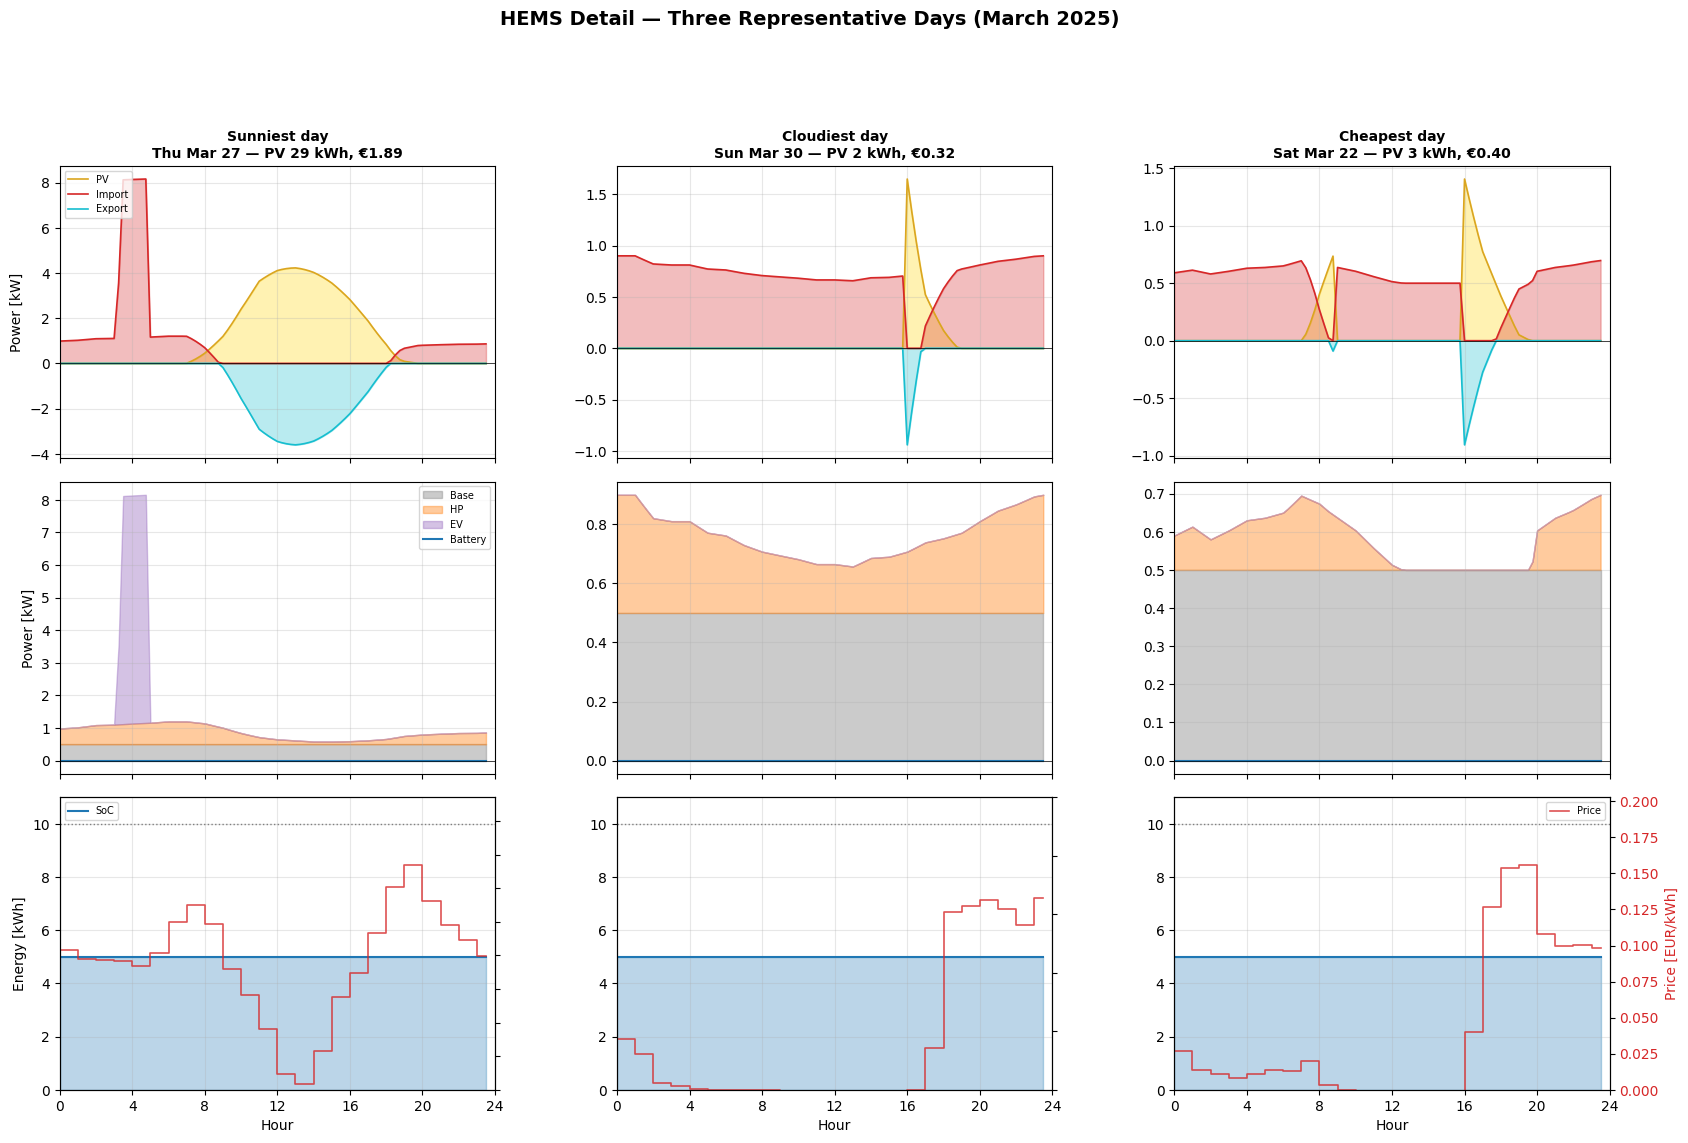

In [23]:
# --- Detailed view: 3 representative days ---
# Only consider days that were actually solved (non-zero cost or generation)
daily_solved = daily.loc[daily["import_kWh"] + daily["export_kWh"] > 0]

# Pick sunniest, cloudiest, and cheapest day — ensuring all three are distinct
day_sunny  = daily_solved["pv_kWh"].idxmax()
day_cloudy = daily_solved["pv_kWh"][daily_solved["pv_kWh"] > 0].idxmin()

# Cheapest day: exclude already-selected days so we get 3 unique days
used = {day_sunny, day_cloudy}
cheap_candidates = daily_solved["avg_price"].drop(index=used, errors="ignore").sort_values()
day_cheap = cheap_candidates.index[0]

selected_days = [
    (day_sunny,  "Sunniest day",  "gold"),
    (day_cloudy, "Cloudiest day", "tab:grey"),
    (day_cheap,  "Cheapest day",  "tab:green"),
]

def get_day_ts(ts_df, day_ts):
    """Get T consecutive steps for a day from the timeseries DataFrame."""
    midnight = pd.Timestamp(day_ts.strftime("%Y-%m-%d"), tz="Europe/Amsterdam")
    start = ts_df.index.searchsorted(midnight)
    return ts_df.iloc[start:start + T]

fig, all_axes = plt.subplots(
    3, 3, figsize=(20, 12),
    sharex=True,
    gridspec_kw={"hspace": 0.08, "wspace": 0.28},
)

for col, (day_ts, label, accent) in enumerate(selected_days):
    ts_day = get_day_ts(ts_march, day_ts)
    h_day = (ts_day.index - ts_day.index[0]).total_seconds() / 3600
    pv_kwh = daily.loc[day_ts, "pv_kWh"]
    cost = daily.loc[day_ts, "cost_eur"]
    avg_p = daily.loc[day_ts, "avg_price"]

    # --- Row 0: Power flows ---
    ax = all_axes[0, col]
    ax.fill_between(h_day, ts_day["P_pv"], alpha=0.3, color="gold")
    ax.plot(h_day, ts_day["P_pv"], color="goldenrod", lw=1.2, label="PV")
    ax.fill_between(h_day, ts_day["P_import"], alpha=0.3, color="tab:red")
    ax.plot(h_day, ts_day["P_import"], color="tab:red", lw=1.2, label="Import")
    ax.fill_between(h_day, -ts_day["P_export"], alpha=0.3, color="tab:cyan")
    ax.plot(h_day, -ts_day["P_export"], color="tab:cyan", lw=1.2, label="Export")
    ax.axhline(0, color="black", lw=0.5)
    ax.set_title(
        f"{label}\n{day_ts.strftime('%a %b %d')} — "
        f"PV {pv_kwh:.0f} kWh, €{cost:.2f}",
        fontsize=10, fontweight="bold",
    )
    ax.grid(True, alpha=0.3)
    if col == 0:
        ax.set_ylabel("Power [kW]")
        ax.legend(loc="upper left", fontsize=7)

    # --- Row 1: Loads + battery ---
    ax = all_axes[1, col]
    ax.fill_between(h_day, ts_day["P_base"], alpha=0.4, color="tab:grey", label="Base")
    ax.fill_between(
        h_day, ts_day["P_base"] + ts_day["P_hp"],
        y2=ts_day["P_base"], alpha=0.4, color="tab:orange", label="HP",
    )
    ev_pos = np.maximum(ts_day["P_ev"].values, 0)
    bottom2 = ts_day["P_base"].values + ts_day["P_hp"].values
    ax.fill_between(h_day, bottom2 + ev_pos, y2=bottom2,
                    alpha=0.4, color="tab:purple", label="EV")
    ax.plot(h_day, ts_day["P_bat"], color="tab:blue", lw=1.5, label="Battery")
    ax.axhline(0, color="black", lw=0.5)
    ax.grid(True, alpha=0.3)
    if col == 0:
        ax.set_ylabel("Power [kW]")
        ax.legend(loc="upper right", fontsize=7)

    # --- Row 2: Battery SoC + price ---
    ax = all_axes[2, col]
    ax.fill_between(h_day, ts_day["E_bat"], alpha=0.3, color="tab:blue")
    ax.plot(h_day, ts_day["E_bat"], color="tab:blue", lw=1.5, label="SoC")
    ax.axhline(battery.E_max, color="grey", ls=":", lw=1)
    ax.set_ylim(0, battery.E_max * 1.1)
    ax.grid(True, alpha=0.3)
    ax.set_xlabel("Hour")
    ax.set_xlim(0, 24)
    ax.set_xticks(range(0, 25, 4))
    if col == 0:
        ax.set_ylabel("Energy [kWh]")
        ax.legend(loc="upper left", fontsize=7)

    # Price on twin axis
    ax2 = ax.twinx()
    ax2.step(h_day, ts_day["price"].values, where="post", color="tab:red",
             ls="-", lw=1.2, alpha=0.8, label="Price")
    p_max = max(ts_day["price"].max() * 1.3, 0.10)
    ax2.set_ylim(0, p_max)
    ax2.tick_params(axis="y", labelcolor="tab:red")
    if col == 2:
        ax2.set_ylabel("Price [EUR/kWh]", color="tab:red")
        ax2.legend(loc="upper right", fontsize=7)
    else:
        ax2.set_yticklabels([])

fig.suptitle(
    "HEMS Detail — Three Representative Days (March 2025)",
    fontweight="bold", fontsize=14, y=1.01,
)
plt.tight_layout()
plt.show()